In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import gsw
from dask.diagnostics import ProgressBar
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from universal import *

In [2]:
ds = xr.open_mfdataset('../data/processed/regridded/CESM1.2_CAM5.*.mean.1x1.nc')
grid = xr.open_dataset('../data/processed/regridded/grid_1x1_depth.nc')

In [3]:
ds.experiment

<xarray.DataArray 'experiment' (experiment: 5)> Size: 380B
array(['deepmip_sens_1xCO2', 'deepmip_sens_9xCO2', 'deepmip_stand_3xCO2',
       'deepmip_stand_6xCO2', 'piControl'], dtype='<U19')
Coordinates:
  * experiment  (experiment) <U19 380B 'deepmip_sens_1xCO2' ... 'piControl'

# Calculations
Calculate density, depth-space overturning circulation, and integrated vertical velocity

In [18]:
# density
ds['sigma0'] = gsw.sigma0(ds['so'],ds['thetao'])
ds['sigma2'] = gsw.sigma2(ds['so'],ds['thetao'])

In [8]:
# overturning
# convert vo to ms-1
vo = ds['vo']*1e-2
# integrate in x
vo_sumx = vo.weighted(grid['dx'].fillna(0)).sum(['x'])
# reverse z dimension
vo_sumx_reversez = vo_sumx.reindex(z=list(reversed(vo_sumx['z'])))
dz_reversez = grid['dz'].reindex(z=list(reversed(grid['dz']['z'])))
# integrate in z
psi_reversez = -1*(vo_sumx_reversez*dz_reversez).cumsum(['z'])
# reverse z dimension
psi = psi_reversez.reindex(z=list(reversed(psi_reversez.z)))
# place in dataset
ds['psi']=psi

In [9]:
# vertical velocity
# Get integrated volume transport across each depth level
# convert wo to ms-1
wo = ds['wo']*1e-2
upwelling = wo.weighted(grid['area'].fillna(0)).sum('x')
ds['upwelling']=upwelling

In [8]:
time = None
if time is None:
    ds = ds.mean('time')
else:
    ds = ds.sel(time=time)

In [10]:
# Get anomaly relative to 1xCO2
dsanom = ds-ds.sel(experiment='deepmip_sens_1xCO2')

In [12]:
# extract bottom values
# can find last entry by finding the depth at which the cumulative sum stops changing
bathy = np.abs(ds.sel(experiment='deepmip_sens_1xCO2')['thetao']).cumsum('z').argmax('z').compute()

## T-S sections

In [20]:
anomaly = False
lon = 339
if anomaly:
    dssec = dsanom.sel(x=lon,method='nearest')
else:
    dssec = ds.sel(x=lon,method='nearest')
    
with ProgressBar():
    dssec = dssec.compute()

[########################################] | 100% Completed | 70.44 s


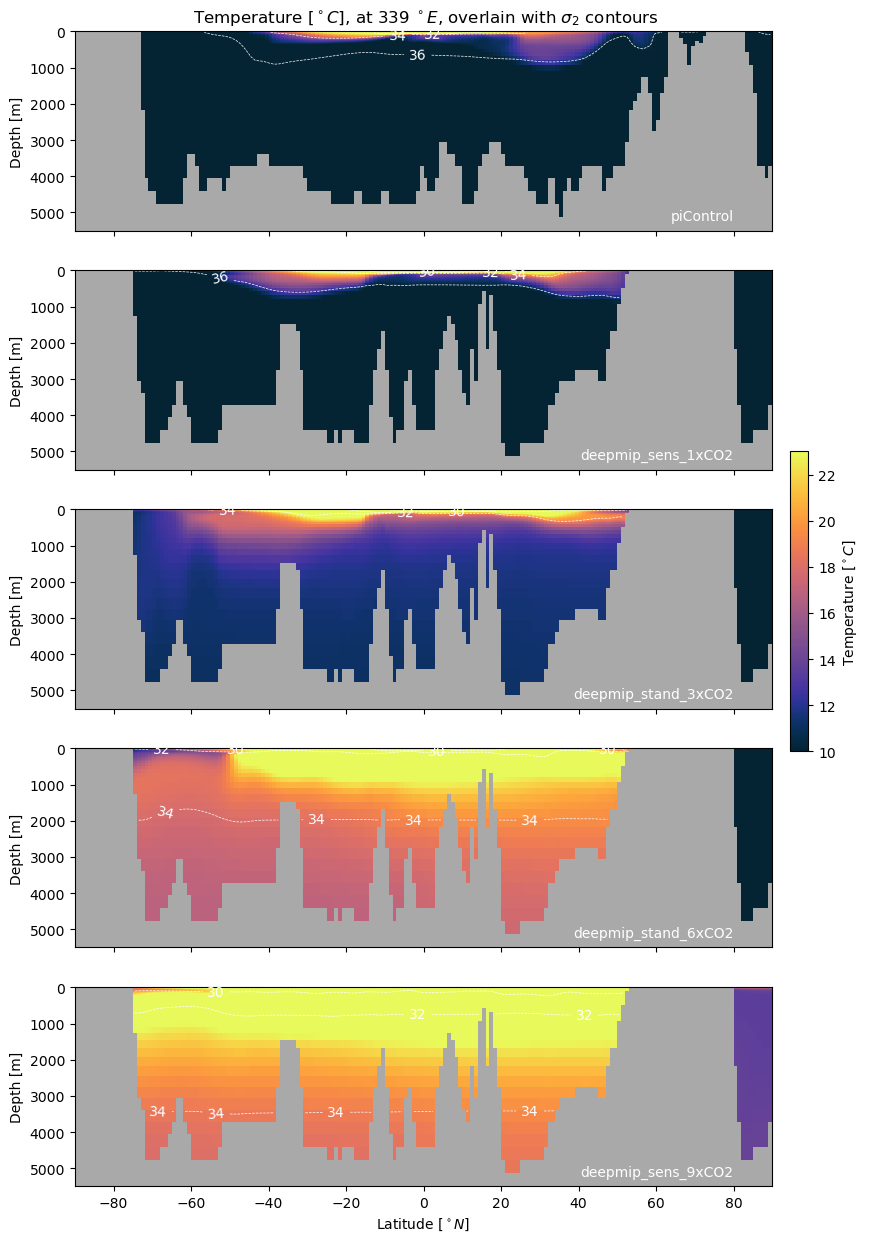

In [21]:
variable = 'thetao'
if variable=='thetao':
    clims = [10,23]
    longname = 'Temperature [$^\circ C$]'
    cmap = cmocean.cm.thermal
    if anomaly:
        clims=[-10,10]
        cmap = cmocean.cm.balance
elif variable=='so':
    longname = 'Salinity [psu]'
    clims = [33.5,36.3]
    cmap = cmocean.cm.haline
    if anomaly:
        clims=[-2,2]
        cmap = cmocean.cm.balance

cmap.set_bad(color='darkgrey')
ne = len(experiments)
fig,axarr = plt.subplots(figsize=(9,3*ne),nrows=ne)
for i,experiment in enumerate(experiments):
    axnow = axarr[i]
    da = dssec.sel(experiment=experiment)[variable]
    sigma2 = dssec.sel(experiment=experiment)['sigma2']
    damask = np.ma.array(da,mask = np.isnan(da))
    im = axnow.pcolormesh(da['y'],da['z'],da,cmap=cmap)
    cs = axnow.contour(da['y'],da['z'],sigma2,[30,32,34,36],colors='w',linestyles='--',linewidths=0.5)
    axnow.clabel(cs)
    axnow.text(80,5200,experiment,color='w',ha='right',fontweight=12)
    axnow.invert_yaxis()
    axnow.set_ylabel(r'Depth [m]')
    if i==ne-1:
        axnow.set_xlabel(r'Latitude [$^\circ N$]')
    else:
        axnow.set_xticklabels([])
    im.set_clim(clims)
    if i==0:
        axnow.set_title(r' '+longname+', at '+str(lon)+' $^\circ E$, overlain with $\sigma_2$ contours')
axc = fig.add_axes([0.92,0.4,0.02,0.2])
cb = fig.colorbar(im,cax=axc)
cb.set_label(longname)

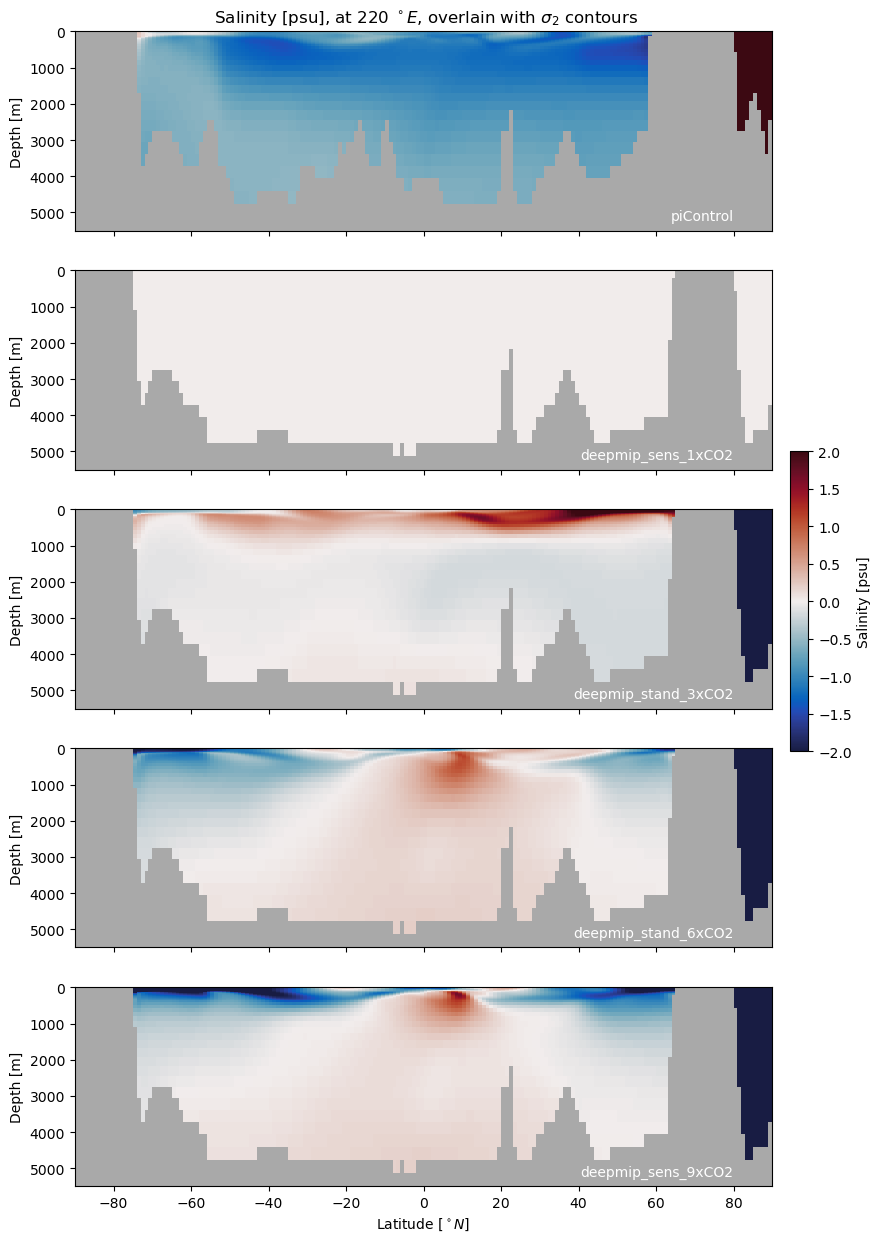

In [180]:
variable = 'so'
if variable=='thetao':
    clims = [10,23]
    longname = 'Temperature [$^\circ C$]'
    cmap = cmocean.cm.thermal
    if anomaly:
        clims=[-10,10]
        cmap = cmocean.cm.balance
elif variable=='so':
    longname = 'Salinity [psu]'
    clims = [33.5,36.3]
    cmap = cmocean.cm.haline
    if anomaly:
        clims=[-2,2]
        cmap = cmocean.cm.balance

cmap.set_bad(color='darkgrey')
ne = len(experiments)
fig,axarr = plt.subplots(figsize=(9,3*ne),nrows=ne)
for i,experiment in enumerate(experiments):
    axnow = axarr[i]
    da = dssec.sel(experiment=experiment)[variable]
    sigma2 = dssec.sel(experiment=experiment)['sigma2']
    damask = np.ma.array(da,mask = np.isnan(da))
    im = axnow.pcolormesh(da['y'],da['z'],da,cmap=cmap)
    cs = axnow.contour(da['y'],da['z'],sigma2,[30,32,34,36],colors='w',linestyles='--',linewidths=0.5)
    axnow.clabel(cs)
    axnow.text(80,5200,experiment,color='w',ha='right',fontweight=12)
    axnow.invert_yaxis()
    axnow.set_ylabel(r'Depth [m]')
    if i==ne-1:
        axnow.set_xlabel(r'Latitude [$^\circ N$]')
    else:
        axnow.set_xticklabels([])
    im.set_clim(clims)
    if i==0:
        axnow.set_title(r' '+longname+', at '+str(lon)+' $^\circ E$, overlain with $\sigma_2$ contours')
axc = fig.add_axes([0.92,0.4,0.02,0.2])
cb = fig.colorbar(im,cax=axc)
cb.set_label(longname)

## Surface maps

In [30]:
z = 3000
anomaly=True

if anomaly:
    dssurf = dsanom.sel(z=z,method='nearest')
else:
    dssurf = ds.sel(z=z,method='nearest')
    
with ProgressBar():
    dssurf = dssurf.compute()

[########################################] | 100% Completed | 73.71 s


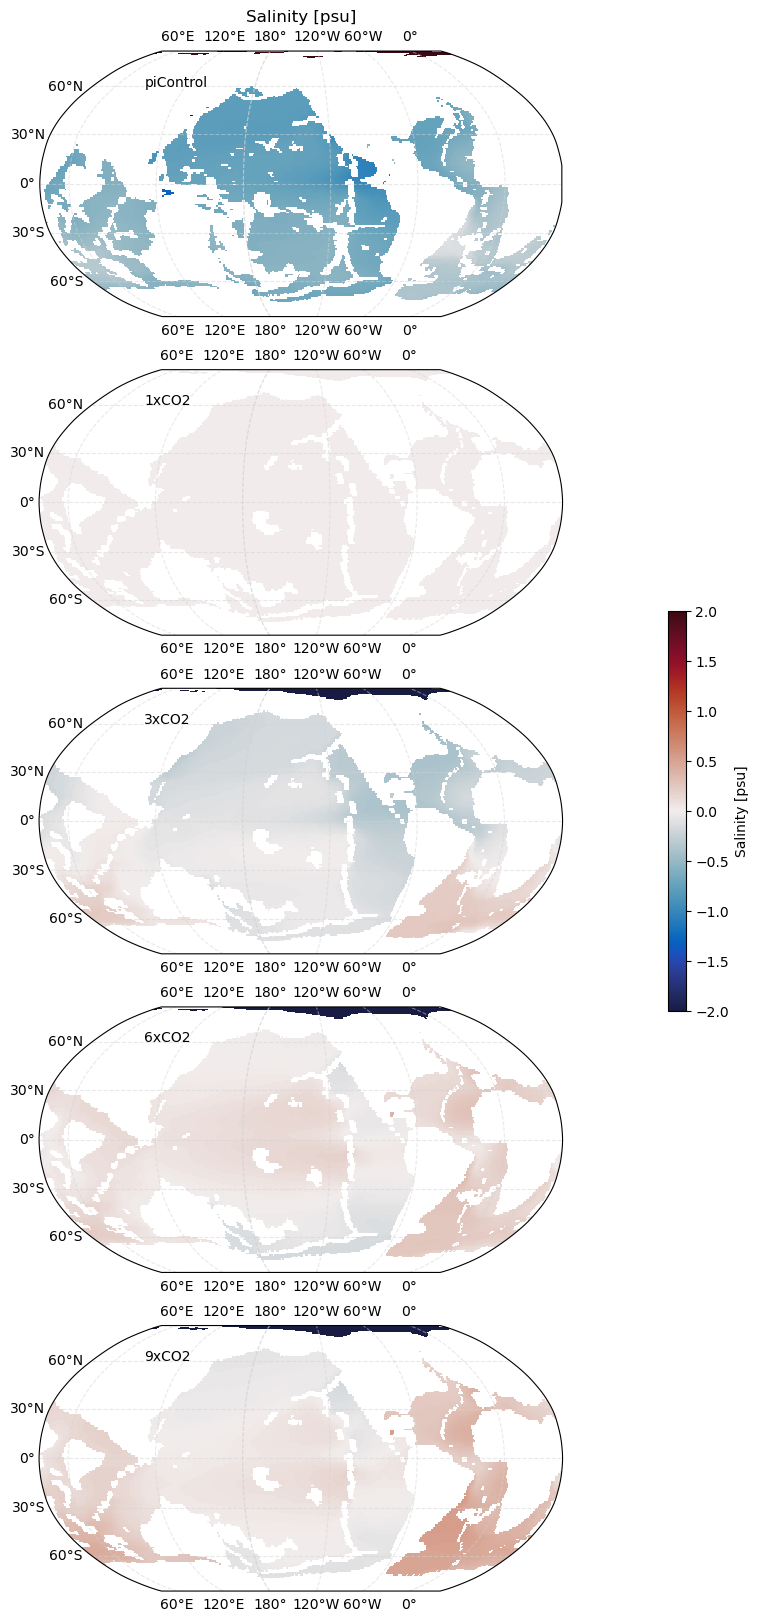

In [31]:
variable = 'so'
if variable=='thetao':
    clims = [10,23]
    longname = 'Temperature [$^\circ C$]'
    cmap = cmocean.cm.thermal
    if anomaly:
        clims=[-10,10]
        cmap = cmocean.cm.balance
elif variable=='so':
    longname = 'Salinity [psu]'
    clims = [33.5,36.3]
    cmap = cmocean.cm.haline
    if anomaly:
        clims=[-2,2]
        cmap = cmocean.cm.balance

cmap.set_bad(color='darkgrey',alpha=0)
ne = len(experiments)
fig,axarr = plt.subplots(figsize=(9,4*ne),nrows=ne,subplot_kw={'projection':ccrs.Robinson(central_longitude=220)})
for i,experiment in enumerate(experiments):
    axnow = axarr[i]
    da = dssurf[variable].sel(experiment=experiment)
    damask = np.ma.array(da,mask = np.isnan(da))
    im = axnow.pcolormesh(da['x'],da['y'],damask,transform=ccrs.PlateCarree(),cmap=cmap)
    axnow.text(85,60,experiment.split('_')[-1],color='k',ha='left',fontweight=12,transform=ccrs.PlateCarree())
    im.set_clim(clims)
    axnow.gridlines(draw_labels=True,color='lightgrey',linestyle='--',alpha=0.5)
    if i==0:
        axnow.set_title(longname)
axc = fig.add_axes([0.92,0.4,0.02,0.2])
cb = fig.colorbar(im,cax=axc)
cb.set_label(longname)

# Stratification

In [164]:
zs = [200,2000]
strat = (ds['sigma2'].sel(z=zs[1],method='nearest')-ds['sigma2'].sel(z=zs[0],method='nearest')).squeeze()
with ProgressBar():
    strat = strat.compute()

[########################################] | 100% Completed | 11.39 s


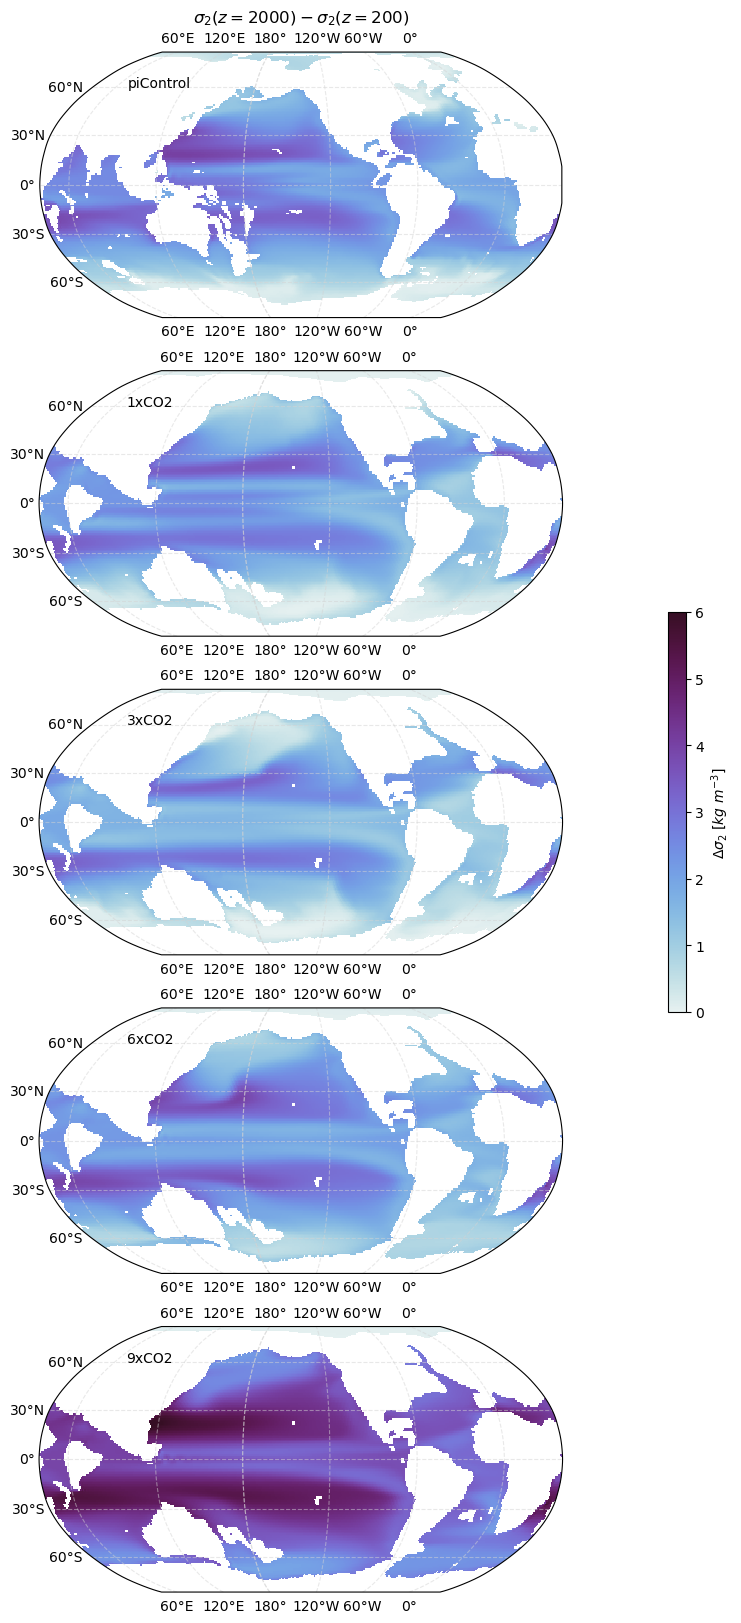

In [166]:
cmap = cmocean.cm.dense
cmap.set_bad(color='darkgrey',alpha=0)
ne = len(experiments)
fig,axarr = plt.subplots(figsize=(9,4*ne),nrows=ne,subplot_kw={'projection':ccrs.Robinson(central_longitude=220)})
for i,experiment in enumerate(experiments):
    axnow = axarr[i]
    da = strat.sel(experiment=experiment)
    # damask = np.ma.array(da,mask = np.isnan(da))
    im = axnow.pcolormesh(da['x'],da['y'],da,transform=ccrs.PlateCarree(),cmap=cmap)
    axnow.text(70,60,experiment.split('_')[-1],color='k',ha='left',fontweight=12,transform=ccrs.PlateCarree())
    im.set_clim([0,6])
    axnow.gridlines(draw_labels=True,color='lightgrey',linestyle='--',alpha=0.5)
    if i==0:
        axnow.set_title(r'$\sigma_2(z='+str(zs[1])+')-\sigma_2(z='+str(zs[0])+')$')
axc = fig.add_axes([0.92,0.4,0.02,0.2])
cb = fig.colorbar(im,cax=axc)
cb.set_label('$\Delta \sigma_2$ [$kg\ m^{-3}$]')

# T-S diagrams

In [56]:
tlims = [-2,48]
slims = [15,40]
tv = np.arange(tlims[0],tlims[1],0.1)
sv = np.arange(slims[0],slims[1],0.02)
sarray,tarray = np.meshgrid(sv,tv)
sig2array = gsw.sigma2(sarray,tarray)

In [58]:
yarray = ds['y']*xr.ones_like(ds['x']) # broadcast latitude
with ProgressBar():
    dss = ds.sel(z=slice(0,100)).weighted(grid['dz']).mean('z').compute()
    dsi = ds.sel(z=slice(1000, 2000)).weighted(grid['dz']).mean('z').compute()
    dsd = ds.sel(z=slice(2000, 9999)).weighted(grid['dz']).mean('z').compute()

[########################################] | 100% Completed | 138.95 s
[########################################] | 100% Completed | 130.09 s
[########################################] | 100% Completed | 123.62 s


In [109]:
experiments = ['piControl','deepmip_stand_3xCO2','deepmip_stand_6xCO2','deepmip_sens_9xCO2']#,'deepmip_sens_1xCO2'

In [111]:
# average variables within latitude bands
latbounds = np.array([[-90,-50],[-50,-10],[-10,10],[10,50],[50,90]])
# preallocate dictionaries to get average datasets
dsm = {}
dsstd = {}
dsim = {}
dsistd = {}
dsdm = {}
dsdstd = {}
# loop through latitude bands
for i in range(len(latbounds)):
    # select area
    lats = latbounds[i,:]
    cond = (yarray>=lats[0]) & (yarray<lats[1])
    # subset dataset
    dsnow = dss.where(cond) # surface ocean
    dsinow = dsi.where(cond) # intermediate ocean
    dsdnow = dsd.where(cond) # deep ocean
    gridnow = grid.where(cond) # horizontal grid
    # average over each region
    # surface ocean
    dsm[i] = dsnow.weighted(gridnow['area'].fillna(0)).mean(['x','y'])
    dsstd[i] = dsnow.weighted(gridnow['area'].fillna(0)).std(['x','y'])
    # intermediate ocean
    dsim[i] = dsinow.weighted(gridnow['area'].fillna(0)).mean(['x','y'])
    dsistd[i] = dsinow.weighted(gridnow['area'].fillna(0)).std(['x','y'])
    # deep ocean
    dsdm[i] = dsdnow.weighted(gridnow['area'].fillna(0)).mean(['x','y'])
    dsdstd[i] = dsdnow.weighted(gridnow['area'].fillna(0)).std(['x','y'])

Text(0.5, 1.0, 'Surface ocean T and S (area-weighted mean $\\pm$ std) and $\\sigma_2$ contours')

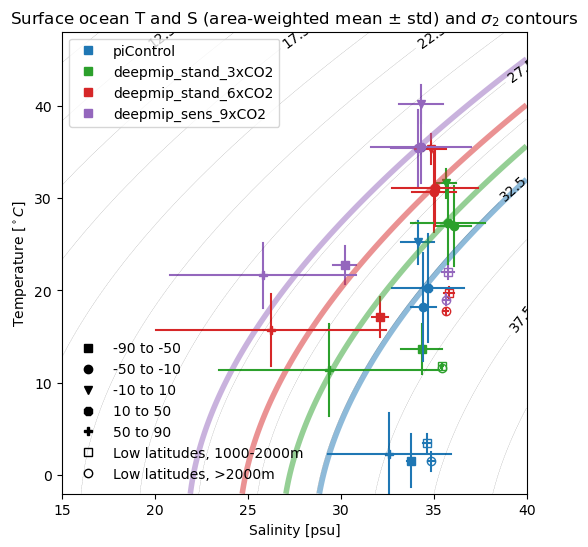

In [112]:
#colors = [name for name,code in mpl.colors.TABLEAU_COLORS.items()]
markers = ['s','o','v','8','P']
# end members
fig,ax = plt.subplots(figsize = (6,6))
em_so = [ds['so'] for i,ds in dsm.items()]
em_to = [ds['thetao'] for i,ds in dsm.items()]
em_so_std = [ds['so'] for i,ds in dsstd.items()]
em_to_std = [ds['thetao'] for i,ds in dsstd.items()]
em_sigma2 = [ds['sigma2'] for i,ds in dsm.items()]
# intermediate ocean (start member)
sim_so = [ds['so'] for i,ds in dsim.items()]
sim_to = [ds['thetao'] for i,ds in dsim.items()]
sim_so_std = [ds['so'] for i,ds in dsistd.items()]
sim_to_std = [ds['thetao'] for i,ds in dsistd.items()]
# deep ocean (start member)
sm_so = [ds['so'] for i,ds in dsdm.items()]
sm_to = [ds['thetao'] for i,ds in dsdm.items()]
sm_so_std = [ds['so'] for i,ds in dsdstd.items()]
sm_to_std = [ds['thetao'] for i,ds in dsdstd.items()]

latstr={}
handles_exp = []
for i in range(len(latbounds)):
    lats = latbounds[i,:]
    latstr[i] = str(lats[0])+' to '+str(lats[1])
    for j,experiment in enumerate(experiments):
        # surface ocean
        s = em_so[i].sel(experiment=experiment)
        t = em_to[i].sel(experiment=experiment)
        ss = em_so_std[i].sel(experiment=experiment)
        ts = em_to_std[i].sel(experiment=experiment)
        
        # intermediate ocean
        si = sim_so[i].sel(experiment=experiment)
        ti = sim_to[i].sel(experiment=experiment)
        sis = sim_so_std[i].sel(experiment=experiment)
        tis = sim_to_std[i].sel(experiment=experiment)
        
        # deep ocean
        sd = sm_so[i].sel(experiment=experiment)
        td = sm_to[i].sel(experiment=experiment)
        sds = sm_so_std[i].sel(experiment=experiment)
        tds = sm_to_std[i].sel(experiment=experiment)
        
        # mean T, S
        h = ax.plot(s,t,linestyle='none',color=colors[experiment],marker=markers[i],label=experiment)
        if i==0:
            handles_exp.append(h[0])
        # standard deviations T, S
        ax.plot([s-ss,s+ss],[t,t],linestyle='-',color=colors[experiment],marker='none')
        ax.plot([s,s],[t-ts,t+ts],linestyle='-',color=colors[experiment],marker='none')
        # contour for low latitude mean density
        if (max(lats)>30) & (min(lats)<30): 
            ax.contour(sv,tv,sig2array,levels=[em_sigma2[i].sel(experiment=experiment)],colors=colors[experiment],linewidths=4, alpha=0.5)
        if (max(lats)>0) & (min(lats)<0): # spans equator
            # intermediate ocean
            ax.plot(si,ti,linestyle='none',color=colors[experiment],marker='s',fillstyle='none',label=experiment)
            ax.plot([si-sis,si+sis],[ti,ti],linestyle='-',color=colors[experiment],marker='none')
            ax.plot([si,si],[ti-tis,ti+tis],linestyle='-',color=colors[experiment],marker='none')
            # deep ocean
            ax.plot(sd,td,linestyle='none',color=colors[experiment],marker='o',fillstyle='none',label=experiment)
            ax.plot([sd-sds,sd+sds],[td,td],linestyle='-',color=colors[experiment],marker='none')
            ax.plot([sd,sd],[td-tds,td+tds],linestyle='-',color=colors[experiment],marker='none')

        
handles_lat = [mpl.lines.Line2D([], [], color='k', linestyle='none', marker=markers[i], label=latstr[i]) for i in range(len(latbounds))]
handles_lat.append(mpl.lines.Line2D([], [], color='k', linestyle='none', marker='s', fillstyle='none',label='Low latitudes, 1000-2000m'))
handles_lat.append(mpl.lines.Line2D([], [], color='k', linestyle='none', marker='o', fillstyle='none',label='Low latitudes, >2000m'))
l = ax.legend(handles=handles_exp,loc='upper left')
ax.legend(handles=handles_lat,loc='lower left',frameon=False)
ax.add_artist(l)
cs = ax.contour(sv,tv,sig2array,levels=15,colors='k',linestyles='--',linewidths=0.1)
ax.clabel(cs,cs.levels[::2],inline=True)
ax.set_ylim(tlims)
ax.set_xlim(slims)
ax.set_ylabel(r'Temperature [$^\circ C$]')
ax.set_xlabel(r'Salinity [psu]')
ax.set_title(r'Surface ocean T and S (area-weighted mean $\pm$ std) and $\sigma_2$ contours')

# Overturning

In [218]:
with ProgressBar():
    sigma2now = ds['sigma2'].mean('x').compute()
    psinow = ds['psi'].compute()

[########################################] | 100% Completed | 10.72 s
[########################################] | 100% Completed | 2.51 ss


In [219]:
bathy1d = bathy.max('x')

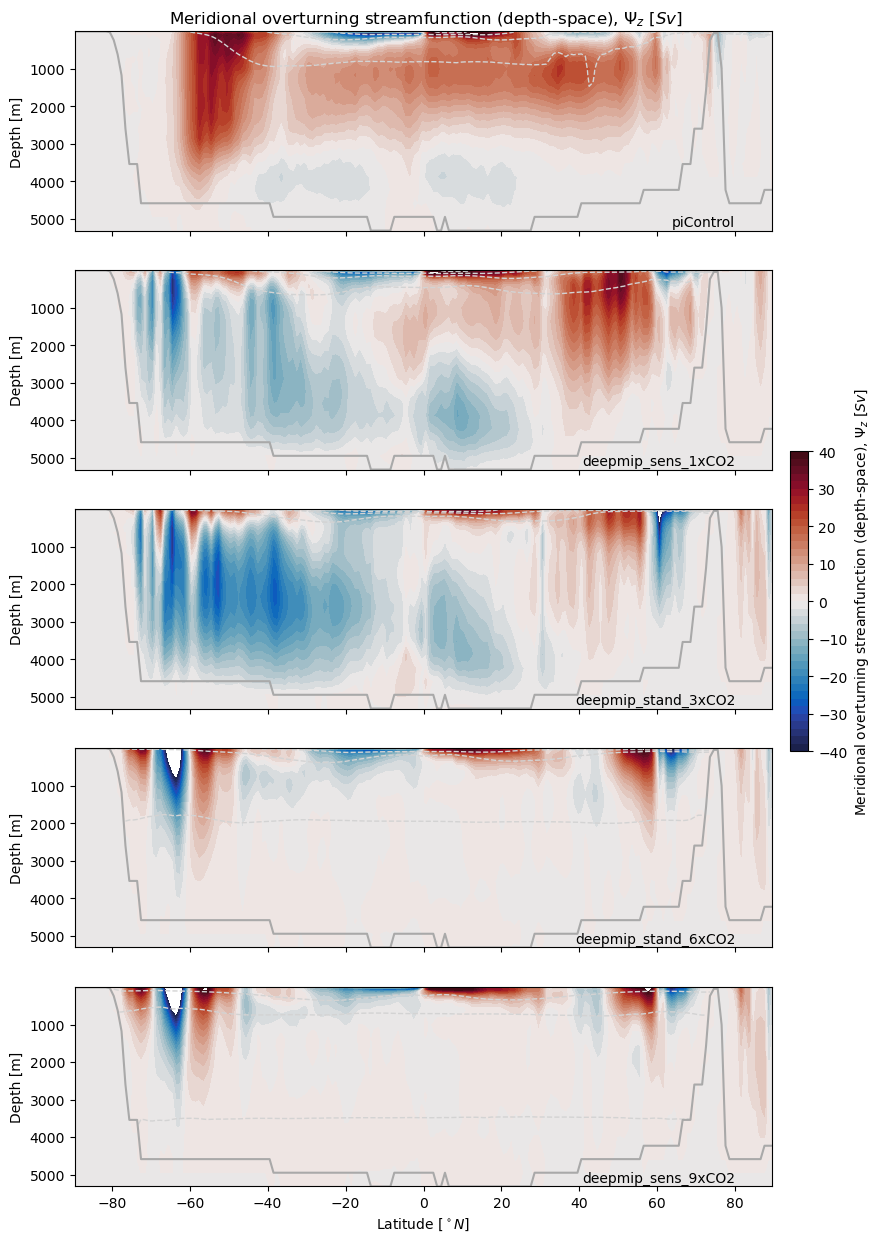

In [224]:
longname = 'Meridional overturning streamfunction (depth-space), $\Psi_z$ [$Sv$]'
experiments = ['piControl','deepmip_sens_1xCO2','deepmip_stand_3xCO2','deepmip_stand_6xCO2','deepmip_sens_9xCO2']

cmap = cmocean.cm.balance
cmap.set_bad(color='darkgrey')
contours = np.arange(-40,41,2)
ne = len(experiments)

fig,axarr = plt.subplots(figsize=(9,3*ne),nrows=ne)
for i,experiment in enumerate(experiments):
    axnow = axarr[i]
    da = (psinow*1e-6).sel(experiment=experiment)
    sigma2 = sigma2now.sel(experiment=experiment)
    damask = np.ma.array(da,mask = np.isnan(da))
    im = axnow.contourf(da['y'],da['z'],da,levels=contours,cmap=cmap)
    cs = axnow.contour(da['y'],da['z'],sigma2,[30,32,34,36],colors='lightgrey',linestyles='--',linewidths=1)
    # axnow.clabel(cs)
    axnow.text(80,5200,experiment,color='k',ha='right',fontweight=12)
    axnow.invert_yaxis()
    axnow.set_ylabel(r'Depth [m]')
    if i==ne-1:
        axnow.set_xlabel(r'Latitude [$^\circ N$]')
    else:
        axnow.set_xticklabels([])
    if i==0:
        axnow.set_title(r' '+longname)
    # add line at bathymetry
    axnow.plot(da['y'],da['z'].isel(z=bathy1d),color='darkgrey')
axc = fig.add_axes([0.92,0.4,0.02,0.2])
cb = fig.colorbar(im,cax=axc)
cb.set_label(longname)

# Vertical velocity

In [264]:
with ProgressBar():
    upwellingnow = ds['upwelling'].mean('time').compute()

[########################################] | 100% Completed | 4.06 ss


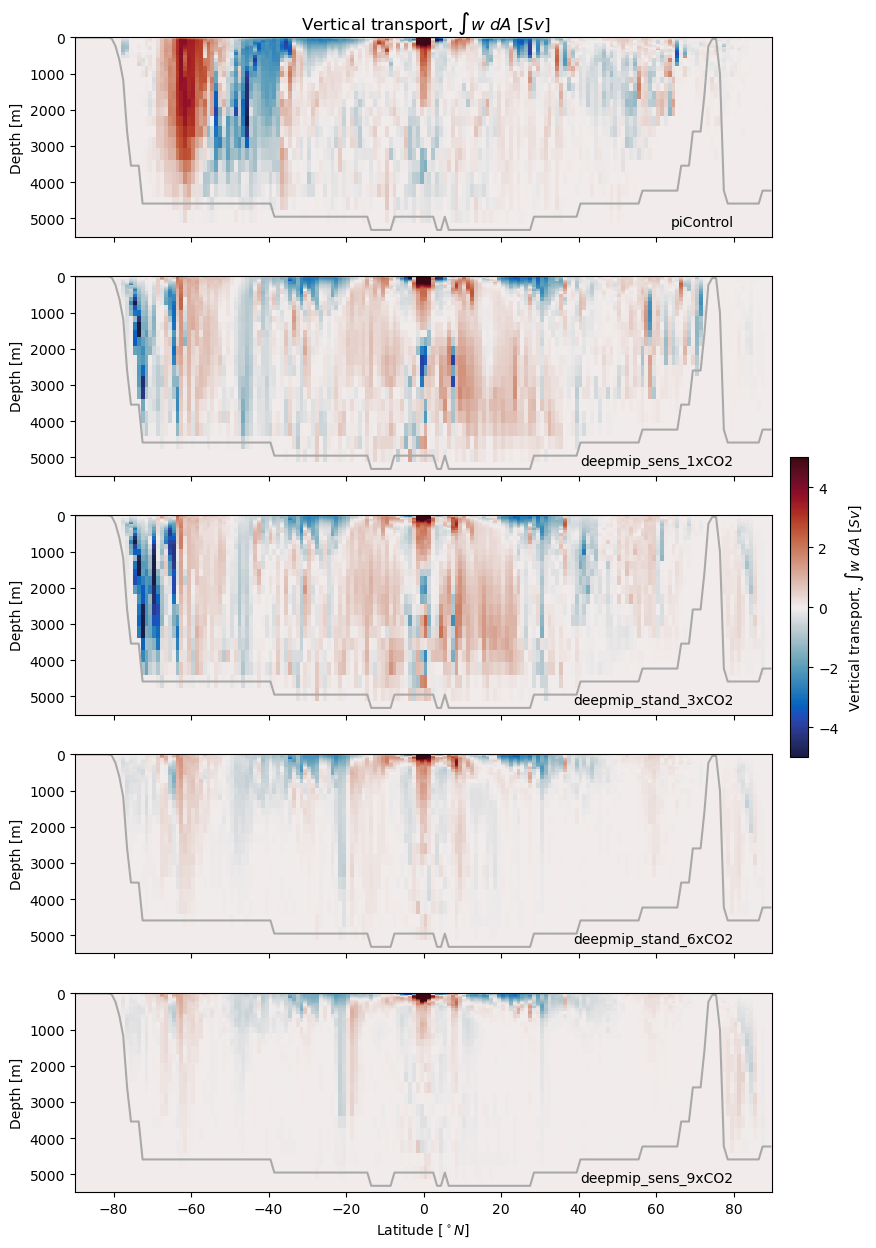

In [268]:
longname = 'Vertical transport, $\int w\ dA$ [$Sv$]'
experiments = ['piControl','deepmip_sens_1xCO2','deepmip_stand_3xCO2','deepmip_stand_6xCO2','deepmip_sens_9xCO2']

cmap = cmocean.cm.balance
cmap.set_bad(color='darkgrey')
clims = [-5,5]
ne = len(experiments)

fig,axarr = plt.subplots(figsize=(9,3*ne),nrows=ne)
for i,experiment in enumerate(experiments):
    axnow = axarr[i]
    da = (upwellingnow*1e-6).sel(experiment=experiment)
    # sigma2 = dssec.sel(experiment=experiment)['sigma2']
    # damask = np.ma.array(da,mask = np.isnan(da))
    im = axnow.pcolormesh(da['y'],da['z'],da,cmap=cmap)
    # cs = axnow.contour(da['y'],da['z'],sigma2,[30,32,34,36],colors='w',linestyles='--',linewidths=0.5)
    # axnow.clabel(cs)
    
    # add line at bathymetry
    axnow.plot(da['y'],da['z'].isel(z=bathy1d),color='darkgrey')
    # label experiment
    axnow.text(80,5200,experiment,color='k',ha='right',fontweight=12)
    axnow.invert_yaxis()
    axnow.set_ylabel(r'Depth [m]')
    if i==ne-1:
        axnow.set_xlabel(r'Latitude [$^\circ N$]')
    else:
        axnow.set_xticklabels([])
    im.set_clim(clims)
    if i==0:
        axnow.set_title(r' '+longname)
axc = fig.add_axes([0.92,0.4,0.02,0.2])
cb = fig.colorbar(im,cax=axc)
cb.set_label(longname)

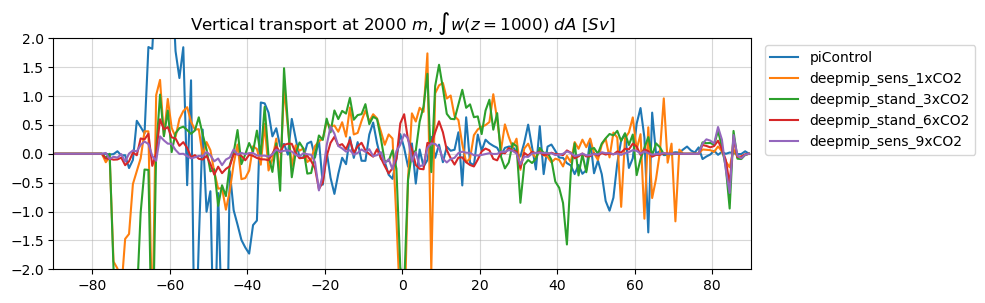

In [300]:
depth_target = 2000
longname = 'Vertical transport at $'+str(depth_target)+'\ m$, $\int w(z=1000)\ dA$ [$Sv$]'
experiments = ['piControl','deepmip_sens_1xCO2','deepmip_stand_3xCO2','deepmip_stand_6xCO2','deepmip_sens_9xCO2']

fig,ax = plt.subplots(figsize=(9,3))
for i,experiment in enumerate(experiments):
    da = upwellingnow.sel(experiment=experiment).sel(z=depth_target,method='nearest')
    ax.plot(da['y'],da*1e-6,label=experiment)
ax.legend(loc='upper left',bbox_to_anchor=(1.01,1))
ax.set_title(longname)
ax.set_xlim(-90,90)
ax.set_ylim(-2,2)
ax.grid(alpha=0.5)

In [302]:
wo = (ds['wo']*grid['area']).sel(z=depth_target,method='nearest')
with ProgressBar():
    wonow = wo.mean('time').compute()

[########################################] | 100% Completed | 2.15 ss


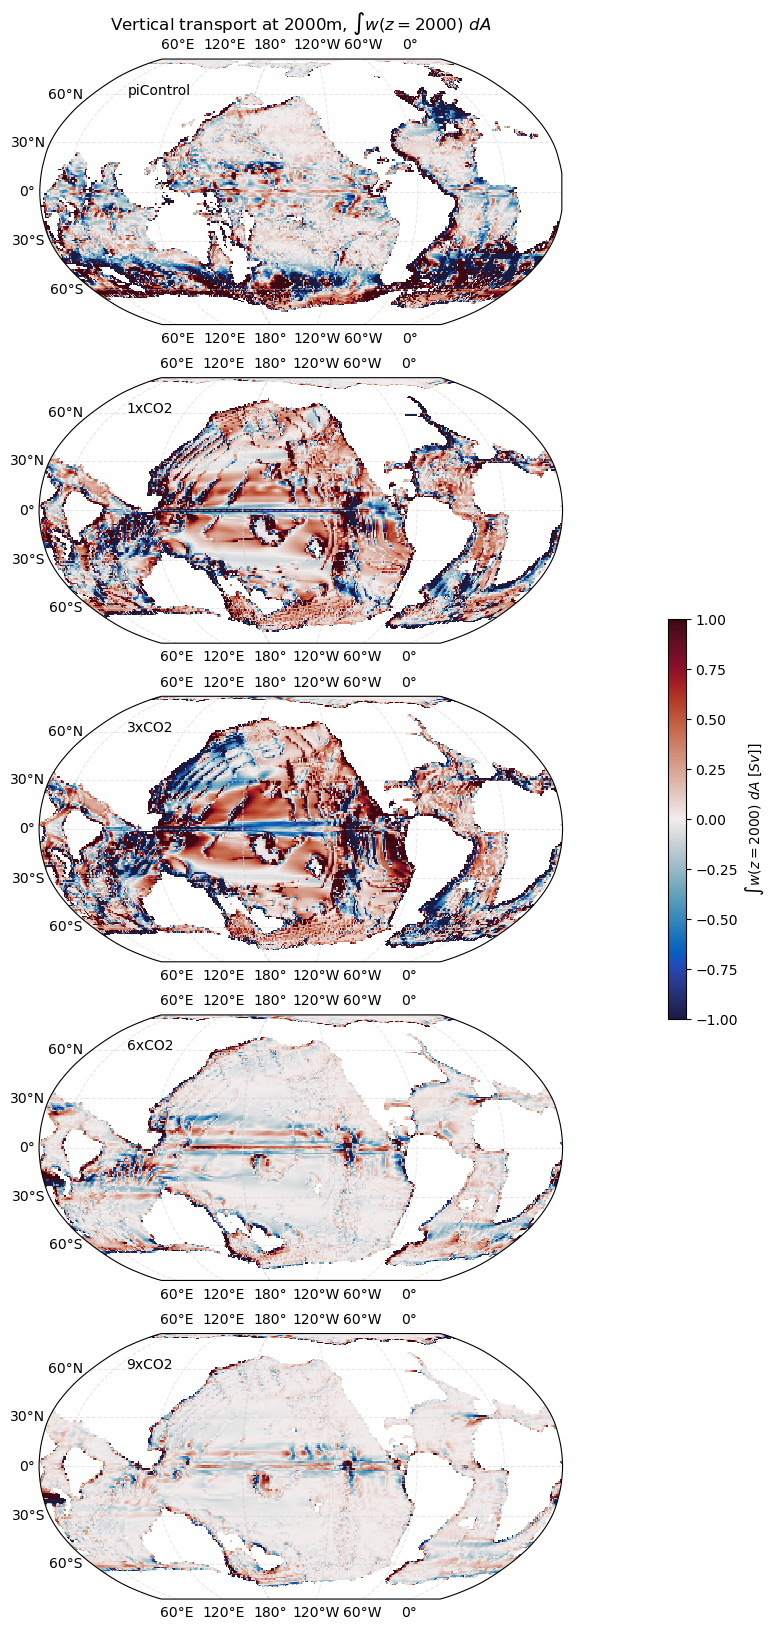

In [306]:
cmap = cmocean.cm.balance
cmap.set_bad(color='darkgrey',alpha=0)
ne = len(experiments)
fig,axarr = plt.subplots(figsize=(9,4*ne),nrows=ne,subplot_kw={'projection':ccrs.Robinson(central_longitude=220)})
for i,experiment in enumerate(experiments):
    axnow = axarr[i]
    da = wonow.sel(experiment=experiment)
    # damask = np.ma.array(da,mask = np.isnan(da))
    im = axnow.pcolormesh(da['x'],da['y'],da*1e-6,transform=ccrs.PlateCarree(),cmap=cmap)
    axnow.text(70,60,experiment.split('_')[-1],color='k',ha='left',fontweight=12,transform=ccrs.PlateCarree())
    im.set_clim([-1,1])
    axnow.gridlines(draw_labels=True,color='lightgrey',linestyle='--',alpha=0.5)
    if i==0:
        axnow.set_title(r'Vertical transport at '+str(depth_target)+'m, $\int w(z='+str(depth_target)+')\ dA$')
axc = fig.add_axes([0.92,0.4,0.02,0.2])
cb = fig.colorbar(im,cax=axc)
cb.set_label(r'$\int w(z='+str(depth_target)+')\ dA$ [$Sv$]')